# NB02: RAG vs Direct

**Question:** Does retrieval help? When? By how much?

This notebook compares RAG-augmented configurations against direct (no-retrieval) baselines:
- Overall effect size
- Distribution of RAG benefit (helps / hurts / neutral)
- RAG uplift by model tier and dataset
- Success factors for RAG

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from analysis_utils import (
    load_all_results, setup_plotting, effect_size,
    compare_best_rag_vs_direct, analyze_rag_benefit_distribution,
    identify_rag_success_factors, plot_rag_benefit_distribution,
    PRIMARY_METRIC, MODEL_PARAMS, MODEL_TIER, BROKEN_MODELS,
    DATASET_COLORS, DATASET_MARKERS, DATASET_LABELS,
)

setup_plotting()
STUDY_PATH = Path("../outputs/smart_retrieval_slm")

df_all = load_all_results(STUDY_PATH)
df = df_all[~df_all['model_short'].isin(BROKEN_MODELS)].copy()
print(f"Loaded {len(df_all)} total, {len(df)} after removing broken models")


  358 experiment(s) use configs outside the current YAML.
  Consider adding these to your study config to explore them:
    • model: 42 exps — Phi-3-mini
    • query_transform: 329 exps — iterative
  Deduplicated: dropped 251 duplicate experiments (same effective config, kept best F1)
Loaded 757 total, 718 after removing broken models


## 1. Overall RAG vs Direct Effect Size

In [2]:
# Per-dataset effect sizes, then combined
print("Overall RAG vs Direct (dataset-stratified)")
print("=" * 60)

datasets = sorted(df['dataset'].unique())
per_ds_results = []

for ds in datasets:
    d_vals = df.loc[(df['exp_type'] == 'direct') & (df['dataset'] == ds), PRIMARY_METRIC].dropna().values
    r_vals = df.loc[(df['exp_type'] == 'rag') & (df['dataset'] == ds), PRIMARY_METRIC].dropna().values
    if len(d_vals) >= 2 and len(r_vals) >= 2:
        d_es, p, interp_ds = effect_size(d_vals, r_vals)
        per_ds_results.append({
            'dataset': ds, 'direct_mean': np.mean(d_vals), 'rag_mean': np.mean(r_vals),
            'n_direct': len(d_vals), 'n_rag': len(r_vals),
            'cohens_d': d_es, 'p_value': p, 'interpretation': interp_ds,
        })
        print(f"  {ds}:")
        print(f"    Direct: mean={np.mean(d_vals):.4f}, n={len(d_vals)}")
        print(f"    RAG:    mean={np.mean(r_vals):.4f}, n={len(r_vals)}")
        print(f"    Cohen's d = {d_es:.3f} ({interp_ds}), p = {p:.2e}")

# Combined: average per-dataset means (stratified)
if per_ds_results:
    combined_direct = np.mean([r['direct_mean'] for r in per_ds_results])
    combined_rag = np.mean([r['rag_mean'] for r in per_ds_results])
    combined_d = np.mean([r['cohens_d'] for r in per_ds_results])
    print(f"\n  Combined (stratified mean across {len(per_ds_results)} datasets):")
    print(f"    Direct: mean={combined_direct:.4f}")
    print(f"    RAG:    mean={combined_rag:.4f}")
    print(f"    Mean Cohen's d = {combined_d:.3f}")

    # Store for summary cell
    d = combined_d
    interp = 'large' if abs(d) >= 0.8 else 'medium' if abs(d) >= 0.5 else 'small' if abs(d) >= 0.2 else 'negligible'

Overall RAG vs Direct (dataset-stratified)
  hotpotqa:
    Direct: mean=0.1514, n=14
    RAG:    mean=0.1472, n=233
    Cohen's d = -0.044 (negligible), p = 8.74e-01
  nq:
    Direct: mean=0.1749, n=14
    RAG:    mean=0.2041, n=222
    Cohen's d = 0.228 (small), p = 4.08e-01
  triviaqa:
    Direct: mean=0.3662, n=14
    RAG:    mean=0.3484, n=221
    Cohen's d = -0.081 (negligible), p = 7.68e-01

  Combined (stratified mean across 3 datasets):
    Direct: mean=0.2308
    RAG:    mean=0.2332
    Mean Cohen's d = 0.034


Best-3 RAG vs Direct Baseline (per model x dataset):


,group,model_short,dataset,direct_mean,top_rag_mean,best_rag,rag_advantage,rag_advantage_pct,n_rag_configs
0,Gemma2-2B / hotpotqa,Gemma2-2B,hotpotqa,0.1452,0.2486,0.2530,0.1034,71.2266,30
1,Gemma2-2B / nq,Gemma2-2B,nq,0.1838,0.3350,0.3483,0.1512,82.2674,28
2,Gemma2-2B / triviaqa,Gemma2-2B,triviaqa,0.4530,0.5697,0.5713,0.1167,25.7652,36
3,Gemma2-9B / hotpotqa,Gemma2-9B,hotpotqa,0.2905,0.3290,0.3305,0.0385,13.2554,31
4,Gemma2-9B / nq,Gemma2-9B,nq,0.3728,0.4163,0.4283,0.0435,11.6685,28
5,Gemma2-9B / triviaqa,Gemma2-9B,triviaqa,0.6449,0.6732,0.6777,0.0283,4.3838,28
6,Llama-3.2-3B / hotpotqa,Llama-3.2-3B,hotpotqa,0.1858,0.2334,0.2355,0.0476,25.5975,38
7,Llama-3.2-3B / nq,Llama-3.2-3B,nq,0.2715,0.3526,0.3670,0.0811,29.8902,33
8,Llama-3.2-3B / triviaqa,Llama-3.2-3B,triviaqa,0.5762,0.5951,0.5989,0.0189,3.2874,34
9,Mistral-7B / hotpotqa,Mistral-7B,hotpotqa,0.1936,0.3030,0.3053,0.1094,56.4960,32


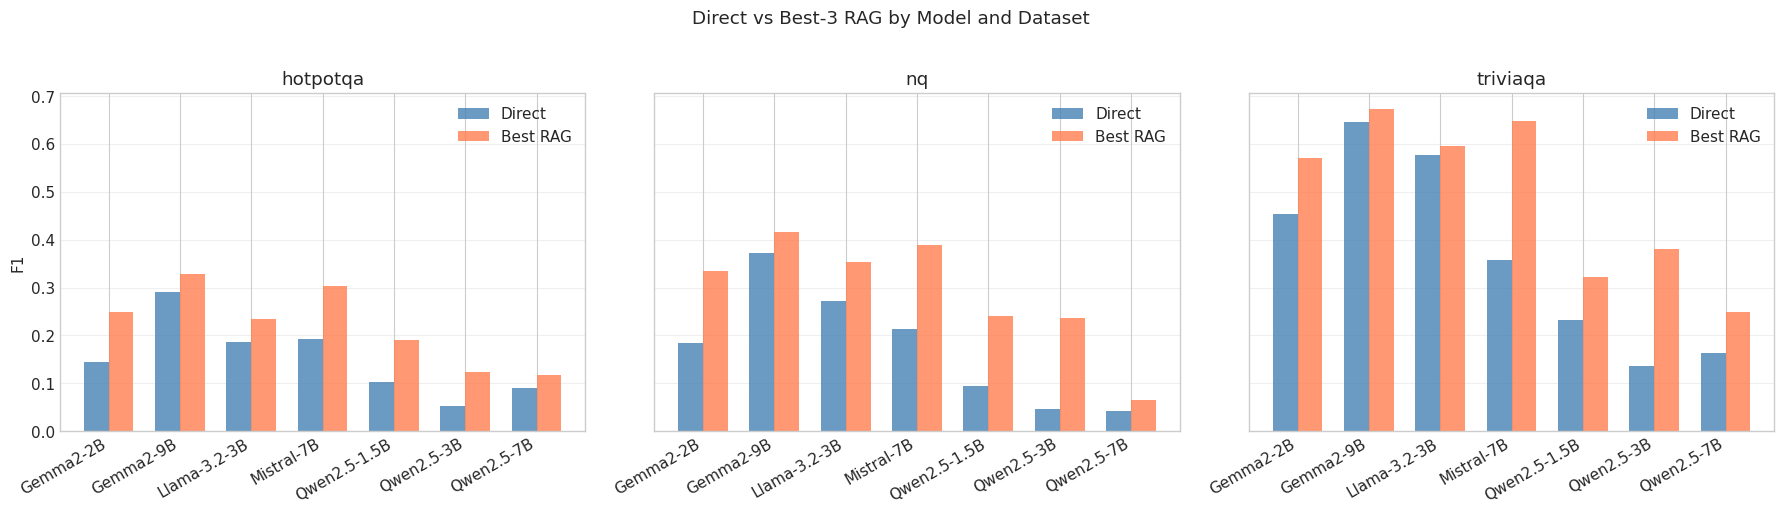

In [3]:
# Best-RAG vs Direct per model+dataset
comparison = compare_best_rag_vs_direct(df, PRIMARY_METRIC, top_k=3)
print("Best-3 RAG vs Direct Baseline (per model x dataset):")
display(comparison.round(4))

# Grouped bar chart
if 'model_short' in comparison.columns and 'dataset' in comparison.columns:
    models = sorted(comparison['model_short'].unique())
    datasets = sorted(comparison['dataset'].unique())

    fig, axes = plt.subplots(1, len(datasets), figsize=(6 * len(datasets), 5), sharey=True)
    if len(datasets) == 1:
        axes = [axes]

    for ax, ds in zip(axes, datasets):
        sub = comparison[comparison['dataset'] == ds].sort_values('model_short')
        x = np.arange(len(sub))
        w = 0.35
        ax.bar(x - w/2, sub['direct_mean'], w, label='Direct', color='steelblue', alpha=0.8)
        ax.bar(x + w/2, sub['top_rag_mean'], w, label='Best RAG', color='coral', alpha=0.8)
        ax.set_xticks(x)
        ax.set_xticklabels(sub['model_short'], rotation=30, ha='right')
        ax.set_title(ds)
        ax.set_ylabel('F1' if ax == axes[0] else '')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

    plt.suptitle('Direct vs Best-3 RAG by Model and Dataset', y=1.02)
    plt.tight_layout()
    plt.show()

## 2. RAG Benefit Distribution

RAG Benefit Distribution
  Helps:    331 (49.0%)
  Hurts:    276 (40.8%)
  Neutral:   69
  Mean uplift when helps:  0.0910
  Mean loss when hurts:    -0.0970


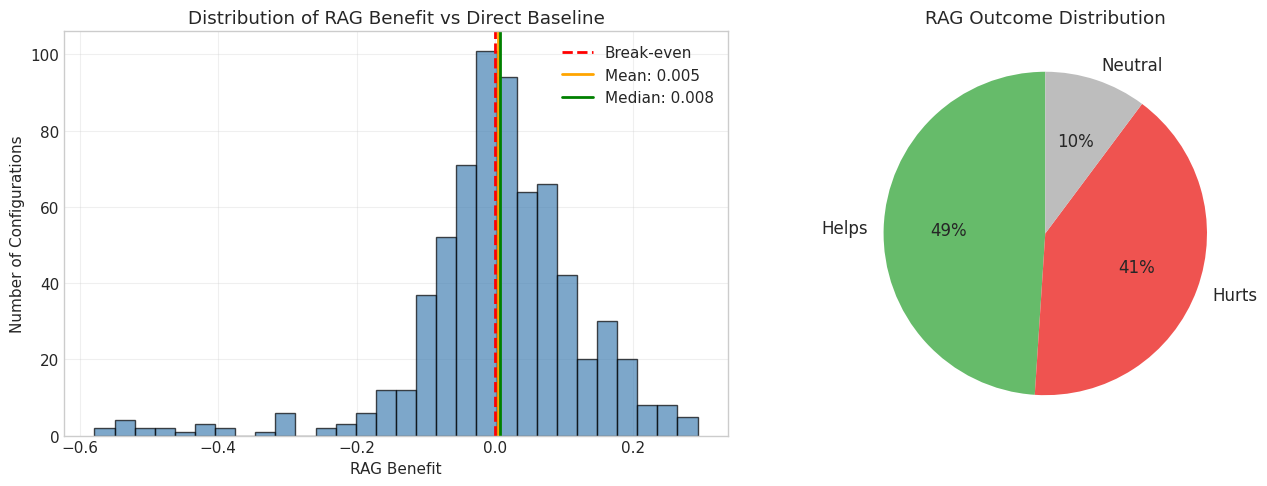

In [4]:
benefit = analyze_rag_benefit_distribution(df, PRIMARY_METRIC)

if benefit:
    print("RAG Benefit Distribution")
    print("=" * 50)
    print(f"  Helps:   {benefit['n_helps']:>4d} ({benefit['pct_helps']:.1f}%)")
    print(f"  Hurts:   {benefit['n_hurts']:>4d} ({benefit['pct_hurts']:.1f}%)")
    print(f"  Neutral: {benefit['n_neutral']:>4d}")
    print(f"  Mean uplift when helps:  {benefit['mean_benefit_when_helps']:.4f}")
    print(f"  Mean loss when hurts:    {benefit['mean_hurt_when_hurts']:.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Histogram
    plot_rag_benefit_distribution(benefit, ax=axes[0])

    # Pie chart
    sizes = [benefit['n_helps'], benefit['n_hurts'], benefit['n_neutral']]
    labels = ['Helps', 'Hurts', 'Neutral']
    colors_pie = ['#66bb6a', '#ef5350', '#bdbdbd']
    axes[1].pie(sizes, labels=labels, colors=colors_pie, autopct='%1.0f%%',
               startangle=90, textprops={'fontsize': 12})
    axes[1].set_title('RAG Outcome Distribution')

    plt.tight_layout()
    plt.show()

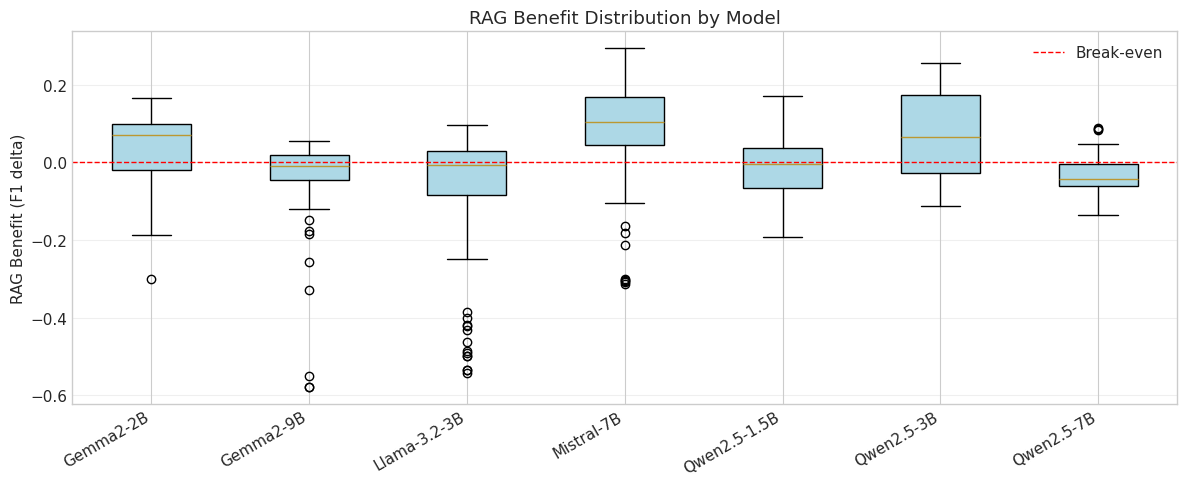

In [5]:
# Box plots of RAG benefit by model
if benefit:
    rag_df = benefit['rag_df']
    models = sorted(rag_df['model_short'].unique())

    fig, ax = plt.subplots(figsize=(12, 5))
    data_by_model = [rag_df[rag_df['model_short'] == m]['rag_benefit'].dropna().values
                     for m in models]
    bp = ax.boxplot(data_by_model, labels=models, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1, label='Break-even')
    ax.set_ylabel('RAG Benefit (F1 delta)')
    ax.set_title('RAG Benefit Distribution by Model')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

## 3. RAG Uplift by Model Tier

Does RAG help weaker models more? Scatter: x = direct baseline F1, y = RAG uplift.

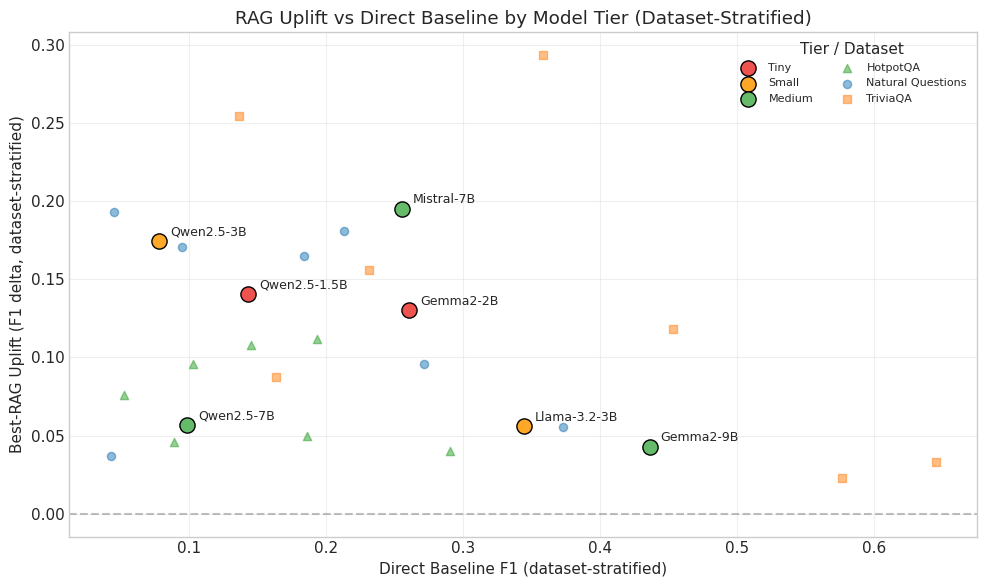

,direct_f1,best_rag_f1,rag_uplift,tier,params_b
model_short,,,,,
Gemma2-2B,0.2607,0.3909,0.1302,tiny,2.0
Gemma2-9B,0.4360,0.4789,0.0428,medium,9.0
Llama-3.2-3B,0.3445,0.4005,0.0560,small,3.0
Mistral-7B,0.2550,0.4502,0.1952,medium,7.0
Qwen2.5-1.5B,0.1430,0.2837,0.1407,tiny,1.5
Qwen2.5-3B,0.0780,0.2524,0.1745,small,3.0
Qwen2.5-7B,0.0985,0.1550,0.0566,medium,7.0


In [6]:
# Compute per-model direct baseline and best-RAG (dataset-stratified)
direct_df = df[df['exp_type'] == 'direct']
rag_df = df[df['exp_type'] == 'rag']

# Stratified: per-(model, dataset) means, then average across datasets
model_direct_strat = (
    direct_df.groupby(['model_short', 'dataset'])[PRIMARY_METRIC].mean()
    .groupby('model_short').mean()
)
model_best_rag_strat = (
    rag_df.groupby(['model_short', 'dataset'])[PRIMARY_METRIC].max()
    .groupby('model_short').mean()
)

scatter_data = pd.DataFrame({
    'direct_f1': model_direct_strat,
    'best_rag_f1': model_best_rag_strat,
}).dropna()
scatter_data['rag_uplift'] = scatter_data['best_rag_f1'] - scatter_data['direct_f1']
scatter_data['tier'] = scatter_data.index.map(lambda m: MODEL_TIER.get(m, 'unknown'))
scatter_data['params_b'] = scatter_data.index.map(lambda m: MODEL_PARAMS.get(m, np.nan))

tier_colors = {'tiny': '#ef5350', 'small': '#ffa726', 'medium': '#66bb6a'}

fig, ax = plt.subplots(figsize=(10, 6))
for tier, color in tier_colors.items():
    sub = scatter_data[scatter_data['tier'] == tier]
    ax.scatter(sub['direct_f1'], sub['rag_uplift'], c=color, s=120,
              label=tier.capitalize(), edgecolors='black', zorder=3)
    for model, row in sub.iterrows():
        ax.annotate(model, (row['direct_f1'], row['rag_uplift']),
                    textcoords='offset points', xytext=(8, 4), fontsize=9)

# Per-dataset markers (secondary layer): x = model direct on that dataset, y = uplift
datasets = sorted(set(direct_df['dataset'].unique()) & set(rag_df['dataset'].unique()))
for ds in datasets:
    ds_direct = direct_df[direct_df['dataset'] == ds].groupby('model_short')[PRIMARY_METRIC].mean()
    ds_best_rag = rag_df[rag_df['dataset'] == ds].groupby('model_short')[PRIMARY_METRIC].max()
    ds_scatter = pd.DataFrame({'direct': ds_direct, 'best_rag': ds_best_rag}).dropna()
    ds_scatter['uplift'] = ds_scatter['best_rag'] - ds_scatter['direct']
    ds_color = DATASET_COLORS.get(ds, 'grey')
    ds_marker = DATASET_MARKERS.get(ds, 'x')
    ds_label = DATASET_LABELS.get(ds, ds)
    ax.scatter(ds_scatter['direct'], ds_scatter['uplift'],
               marker=ds_marker, color=ds_color, s=35, alpha=0.5,
               label=ds_label, zorder=2)

ax.axhline(y=0, color='grey', linestyle='--', alpha=0.5)
ax.set_xlabel('Direct Baseline F1 (dataset-stratified)')
ax.set_ylabel('Best-RAG Uplift (F1 delta, dataset-stratified)')
ax.set_title('RAG Uplift vs Direct Baseline by Model Tier (Dataset-Stratified)')
ax.legend(title='Tier / Dataset', fontsize=8, ncol=2)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

display(scatter_data.round(4))

## 4. RAG Benefit by Dataset

,dataset,direct_mean,rag_mean,cohens_d,p_value,interpretation
0,hotpotqa,0.1514,0.1472,-0.0436,0.8741,negligible
1,nq,0.1749,0.2041,0.2282,0.4085,small
2,triviaqa,0.3662,0.3484,-0.0815,0.7677,negligible


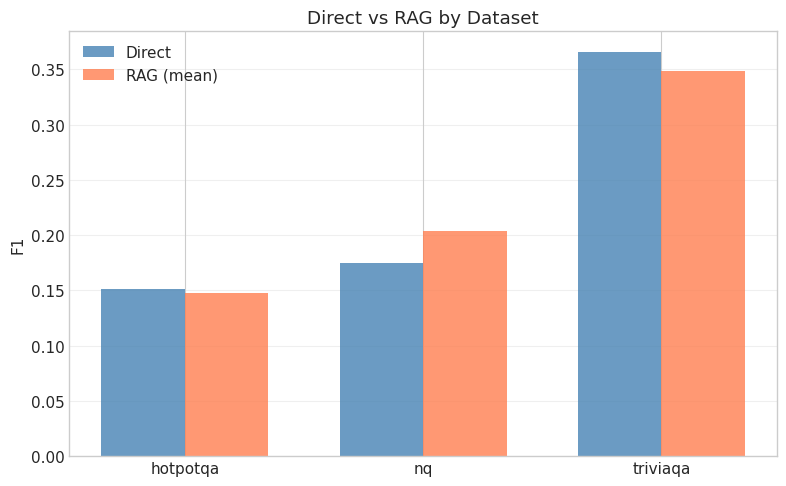

In [7]:
# Per-dataset effect sizes (direct vs all RAG)
datasets = sorted(df['dataset'].unique())
ds_effects = []
for ds in datasets:
    d_vals = df.loc[(df['exp_type'] == 'direct') & (df['dataset'] == ds), PRIMARY_METRIC].dropna().values
    r_vals = df.loc[(df['exp_type'] == 'rag') & (df['dataset'] == ds), PRIMARY_METRIC].dropna().values
    if len(d_vals) >= 2 and len(r_vals) >= 2:
        d, pval, interp = effect_size(d_vals, r_vals)
        ds_effects.append({
            'dataset': ds, 'direct_mean': np.mean(d_vals), 'rag_mean': np.mean(r_vals),
            'cohens_d': d, 'p_value': pval, 'interpretation': interp,
        })

ds_effect_df = pd.DataFrame(ds_effects)
display(ds_effect_df.round(4))

# Grouped bars
fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(ds_effect_df))
w = 0.35
ax.bar(x - w/2, ds_effect_df['direct_mean'], w, label='Direct', color='steelblue', alpha=0.8)
ax.bar(x + w/2, ds_effect_df['rag_mean'], w, label='RAG (mean)', color='coral', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(ds_effect_df['dataset'])
ax.set_ylabel('F1')
ax.set_title('Direct vs RAG by Dataset')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Success Factors for RAG

In [8]:
success_factors = identify_rag_success_factors(df, PRIMARY_METRIC)

if success_factors:
    for factor, table in success_factors.items():
        if table.empty:
            continue
        print(f"\n{factor}:")
        display(table.round(3))


retriever_type:


,pct_helps,mean_benefit,std_benefit,mean_benefit_pct
retriever_type,,,,
hybrid,0.687,0.037,0.110,46.874
hierarchical,0.601,0.030,0.090,26.378
dense,0.449,-0.002,0.114,11.231



embedding_model:


,pct_helps,mean_benefit,std_benefit,mean_benefit_pct
embedding_model,,,,
BGE-large,0.516,0.006,0.117,17.990
GTE-Qwen2-1.5B,0.496,0.010,0.105,18.469
BGE-M3,0.378,-0.007,0.104,8.343



reranker:


,pct_helps,mean_benefit,std_benefit,mean_benefit_pct
reranker,,,,
bge-v2,0.503,0.007,0.115,17.610
bge,0.459,-0.004,0.116,3.813
none,0.450,0.002,0.090,20.392



prompt:


,pct_helps,mean_benefit,std_benefit,mean_benefit_pct
prompt,,,,
fewshot_3,0.703,0.067,0.079,49.763
concise_strict,0.653,0.022,0.081,28.479
fewshot_1,0.641,0.050,0.076,44.568
concise,0.343,0.003,0.079,-6.100
concise_json,0.343,-0.046,0.109,-8.307
extractive_quoted,0.218,-0.073,0.105,-26.814
cot,0.000,-0.181,0.104,-80.424
cot_final,0.000,-0.190,0.129,-80.779
extractive,0.000,-0.103,0.070,-48.531



query_transform:


,pct_helps,mean_benefit,std_benefit,mean_benefit_pct
query_transform,,,,
multiquery,0.544,0.014,0.105,23.039
iterative,0.486,0.002,0.117,15.783
none,0.474,0.004,0.110,15.186
hyde,0.439,-0.001,0.125,10.907



top_k:


,pct_helps,mean_benefit,std_benefit,mean_benefit_pct
top_k,,,,
15,0.583,0.022,0.121,37.367
10,0.489,0.009,0.113,16.281
20,0.483,-0.001,0.108,13.680
5,0.430,-0.011,0.113,10.330
3,0.425,-0.009,0.102,4.174


## 6. Summary

Key takeaways:
- Overall RAG vs Direct effect size and significance
- What fraction of RAG configs help vs hurt
- Which model tiers benefit most from RAG
- Dataset-specific patterns

In [9]:
if benefit:
    print("RAG vs DIRECT SUMMARY")
    print("=" * 60)
    print(f"Overall Cohen's d:    {d:.3f} ({interp})")
    print(f"RAG helps in:         {benefit['pct_helps']:.0f}% of configurations")
    print(f"Best RAG uplift:      {benefit['best_rag_benefit']:.4f}")
    print(f"Worst RAG penalty:    {benefit['worst_rag_benefit']:.4f}")

RAG vs DIRECT SUMMARY
Overall Cohen's d:    -0.081 (negligible)
RAG helps in:         49% of configurations
Best RAG uplift:      0.2933
Worst RAG penalty:    -0.5791
